# Prepare a dataset for training Mask R-CNN object detection

In [ ]:
dataset_dir = '/content/drive/MyDrive/MyProjects/object_detection_with_MaskRCNN/Dataset'

## Explore the images

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
img_list = [name for name in os.listdir(os.path.join(dataset_dir,'train/Taxi/images'))]
img_list

['000bd0b4fa27644c.jpg',
 '00645618375350cf.jpg',
 '01b7fbf0cc2dc3a2.jpg',
 '023463e93c2fa36e.jpg',
 '024f984a12f0e0ac.jpg',
 '02512b320806e9a7.jpg',
 '029df550573178fd.jpg',
 '040867934b54eefb.jpg',
 '07b49b4f2f52e46a.jpg',
 '08489e58e5610d6e.jpg',
 '0ad8b8997381abc0.jpg',
 '0c840974bf0844d9.jpg',
 '0ed0aeb1d67d51c2.jpg',
 '0f01310e129febcb.jpg',
 '1359b011ba00fd66.jpg',
 '15c45dbd4ef65448.jpg',
 '19c51d6e1afe9390.jpg',
 '1bf06861c5e5298b.jpg',
 '2640fe8c188a82c4.jpg',
 '29befc11b302d1c4.jpg',
 '2caac0d9eb51d850.jpg',
 '2d3ba75bcd24e41c.jpg',
 '335f04d058035bee.jpg',
 '34e5c09e01d30529.jpg',
 '38cab9fc33a36f05.jpg',
 '3af69f60a18f137a.jpg',
 '3d9a7412bd178cbf.jpg',
 '3eae0582bd32a794.jpg',
 '4081939714aab29f.jpg',
 '40a4b16fbd7e56a0.jpg',
 '485a542db5576a98.jpg',
 '4a73f9faf0ed917d.jpg',
 '4aca71e1ab1c2e38.jpg',
 '50de37badd67a06d.jpg',
 '5135a4528d9b32be.jpg',
 '5205c741cf9d8c4e.jpg',
 '534fe66ccd986d4a.jpg',
 '5361b369f7a7d183.jpg',
 '5a64f002929521e8.jpg',
 '5b07d68e111fb3f4.jpg',


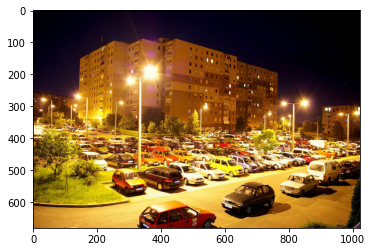

Width :  1024    Height :  681


In [ ]:
# select random image in dataset and plot it
img_name = random.choice(img_list)
img = load_img(os.path.join(dataset_dir, 'train/Taxi/images/'+img_name))
plt.imshow(img)
plt.show()
print('Width : ', img.width, '   Height : ', img.height)

In [ ]:
label_path = os.path.join(train_set_dir, 'annotations/'+img_name[:-4]+'.txt')

In [ ]:
# get image information from label file
with open(label_path) as file:
  temp = file.read().splitlines()

In [ ]:
# extract boxes form information
boxes = []
for line in temp:
  box = list(map(float, line.split()[1:]))
  boxes.append(box)

boxes

[[241.92, 500.98037400000004, 352.0, 585.544911],
 [327.04, 592.591899, 574.72, 680.359179],
 [549.76, 454.854201, 663.04, 525.9649019999999]]

## Develop Mask R-CNN dataset

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
sys.path.append('Mask_RCNN')
from mrcnn.utils import Dataset

In [61]:
class taxiDataset(Dataset):
  
  # load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
    """
    Load the dataset definitions : image id, image path and annotation path
    """

    # define one class to train
    self.add_class("dataset", 1, "taxi")
    
    # define image and annotation locations
    if is_train==True:
      # define location for training set
      images_dir = dataset_dir + '/train/Taxi/images/'
      annotations_dir = dataset_dir + '/train/Taxi/annotations/'
    else :
      # define location for test set
      images_dir = dataset_dir + '/test/Taxi/images/'
      annotations_dir = dataset_dir + '/test/Taxi/annotations/'

    # find all images
    for filename in os.listdir(images_dir):

      # extract image id
      image_id = filename[:-4]
      
      # extract paths
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.txt'

      # add to dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

  def extract_boxes(self, filename):
    """
    - extract bounding boxes from an annotation file
    """
    
    # define list of boxes
    boxes = []

    # open the txt annotation file and read the information
    with open(filename) as file:
      temp = file.read().splitlines()

    # extract each box from each line
    for line in temp:
      box = list(map(float, line.split()[1:]))
      boxes.append(box)

    return boxes
  
  def load_mask(self, image_id):
    """
    load the mask of an image
    """

    # get details of image
    info = self.image_info[image_id]

    # define image file location
    img_path = info['path']

    # load image and get its dimensions
    img = load_img(img_path)
    w = img.width
    h = img.height
    
    # define annotation file location
    ann_path = info['annotation']

    # load boxes
    boxes = self.extract_boxes(ann_path)

    # create mask manually 
    # since out dataset has only bounding boxes 
    # we'll then generate rectangle mask from the boxes

    # create one array for all masks, each on a different channel
    masks = np.zeros([h, w, len(boxes)], dtype='uint8')

    # create masks and class id
    class_ids = []
    for i,box in enumerate(boxes):
      row_s, row_e = int(box[1]), int(box[3])
      col_s, col_e = int(box[0]), int(box[2])
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('taxi'))
    
    return masks, np.asarray(class_ids, dtype='int32')
  
  def image_reference(self, image_id):
    """
    load an image reference
    """
    info = self.image_info[image_id]
    return info['path']

In [62]:
# create train set
train_set = taxiDataset()
train_set.load_dataset(dataset_dir, is_train=True)
train_set.prepare()

# create test set
test_set = taxiDataset()
test_set.load_dataset(dataset_dir, is_train=False)
test_set.prepare()

print('Train : ', len(train_set.image_ids))
print('Test : ', len(test_set.image_ids))

Train :  100
Test :  20


# Test the taxiDataset object

In [ ]:
train_set.class_names

['BG', 'taxi']

In [ ]:
train_set.class_info

[{'id': 0, 'name': 'BG', 'source': ''},
 {'id': 1, 'name': 'taxi', 'source': 'dataset'}]

In [ ]:
train_set.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
# load an image
image_id = random.choice(train_set.image_ids)
image = train_set.load_image(image_id)
print(image.shape)

(771, 1024, 3)


In [ ]:
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(771, 1024, 1)


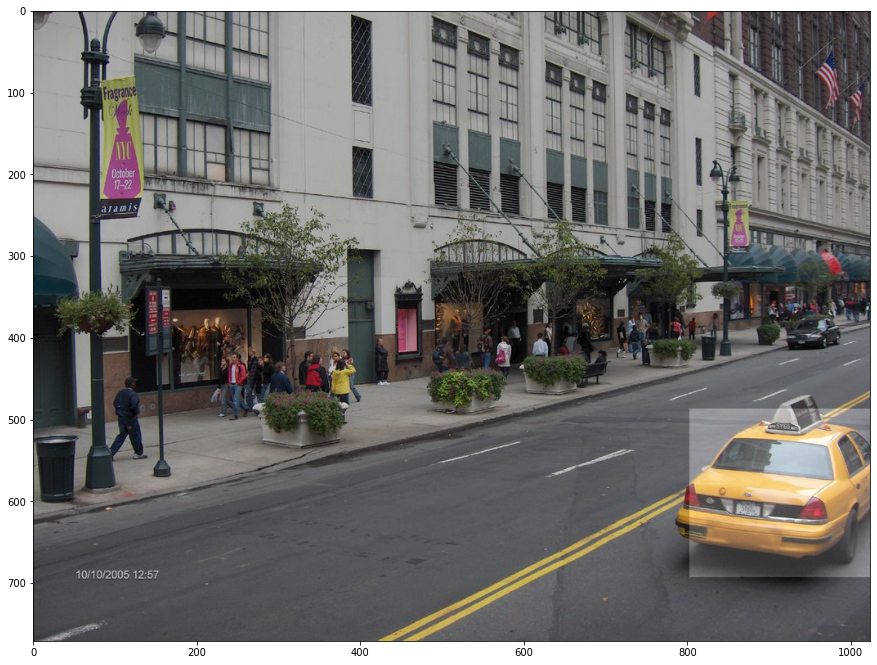

In [ ]:
# plot image
fig = plt.figure(figsize=(15,15))
plt.imshow(image)

# plot mask
for i in range(mask.shape[2]):
  plt.imshow(mask[:,:,i], cmap='gray', alpha=0.2)

plt.show()

# Load all of the image info objects

In [ ]:
for image_id in train_set.image_ids:
  # load image info
  info = train_set.image_info[image_id]
  # display on the console
  print(info)

{'id': '000bd0b4fa27644c', 'source': 'dataset', 'path': '/content/drive/MyDrive/MyProjects/object_detection_with_MaskRCNN/Dataset/train/Taxi/images/000bd0b4fa27644c.jpg', 'annotation': '/content/drive/MyDrive/MyProjects/object_detection_with_MaskRCNN/Dataset/train/Taxi/annotations/000bd0b4fa27644c.txt'}
{'id': '00645618375350cf', 'source': 'dataset', 'path': '/content/drive/MyDrive/MyProjects/object_detection_with_MaskRCNN/Dataset/train/Taxi/images/00645618375350cf.jpg', 'annotation': '/content/drive/MyDrive/MyProjects/object_detection_with_MaskRCNN/Dataset/train/Taxi/annotations/00645618375350cf.txt'}
{'id': '01b7fbf0cc2dc3a2', 'source': 'dataset', 'path': '/content/drive/MyDrive/MyProjects/object_detection_with_MaskRCNN/Dataset/train/Taxi/images/01b7fbf0cc2dc3a2.jpg', 'annotation': '/content/drive/MyDrive/MyProjects/object_detection_with_MaskRCNN/Dataset/train/Taxi/annotations/01b7fbf0cc2dc3a2.txt'}
{'id': '023463e93c2fa36e', 'source': 'dataset', 'path': '/content/drive/MyDrive/MyPro

# Display result with mrcnn.visualize.display_instances()

In [ ]:
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

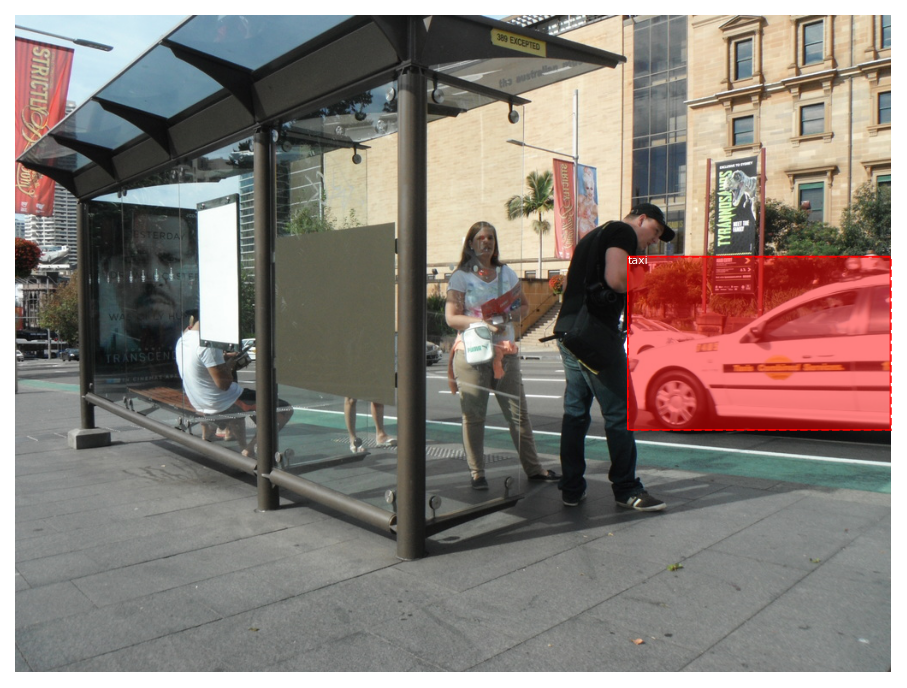

In [ ]:
# get random image
image_id = random.choice(train_set.image_ids)

# load the image 
image = train_set.load_image(image_id)

# load the masks and class ids
mask, class_ids = train_set.load_mask(image_id)

# extract bounding boxes
bbox = extract_bboxes(mask)

# display image with masks and bboxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)